In [25]:
import geopandas as gpd
import xarray as xr
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import pandas as pd
import getpass
import pydap

### EEZ shapefile
https://www.marineregions.org/downloads.php

https://ows.emodnet-humanactivities.eu/geonetwork/srv/eng/catalog.search#/metadata/d4a3fede-b0aa-485e-b4b2-77e8e3801fd0


In [7]:
eez = gpd.read_file('../data/EMODnet_HA_OtherManagementAreas_EEZ_v11_20210506/EMODnet_HA_OtherManagementAreas_EEZ_v11_20210506.shp')

In [8]:
countries = ['Belgium',
'Germany',
'Denmark',
'Estonia',
'Spain',
'Finland',
'France',
'Ireland',
'Lithuania',
'Latvia',
'Netherlands',
'Poland',
'Portugal',
'Sweden',
'United Kingdom']

In [9]:
eezSDG14 = eez[eez.Territory.isin(countries)]
# we increase by one degree to be safe
boundsEEZ = (eezSDG14.total_bounds[0]-1, eezSDG14.total_bounds[1]-1, eezSDG14.total_bounds[2]+1, eezSDG14.total_bounds[3]+1)
boundsEEZ

(-17.073890430099198,
 33.877599219328545,
 29.208985437228193,
 68.08058834047961)

### Copernicus Marine Data
https://data.marine.copernicus.eu/product/MULTIOBS_GLO_BIO_CARBON_SURFACE_REP_015_008/description

In [22]:
# open yearly pH data, create dic to store country-year data, clip to country EEZ and calculate mean pH
years = [2012,2016,2021]
ph = {}
for year in years:
    ph["{0}".format(year)] = xr.open_dataset('../data/pH{0}.nc'.format(year))
    
phCountryGrid = {}
for year in years:  
    phCountryGrid["{0}".format(year)] = {}
    for country in countries:
        phCountryGrid["{0}".format(year)]["{0}".format(country)] = {}
phCountryVal = phCountryGrid.copy()

for k,v in ph.items():
    ph[k] = v.mean(dim='time')
    ph[k] = ph[k].rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    ph[k] = ph[k].rio.write_crs("epsg:4326", inplace=True)
    for country in countries:
        phCountryGrid["{0}".format(k)][country] = ph[k].rio.clip(eezSDG14[eezSDG14.Territory==country].geometry.apply(mapping), eezSDG14.crs, drop=False)
        phCountryVal["{0}".format(k)][country] = phCountryGrid["{0}".format(k)][country].ph.mean().values

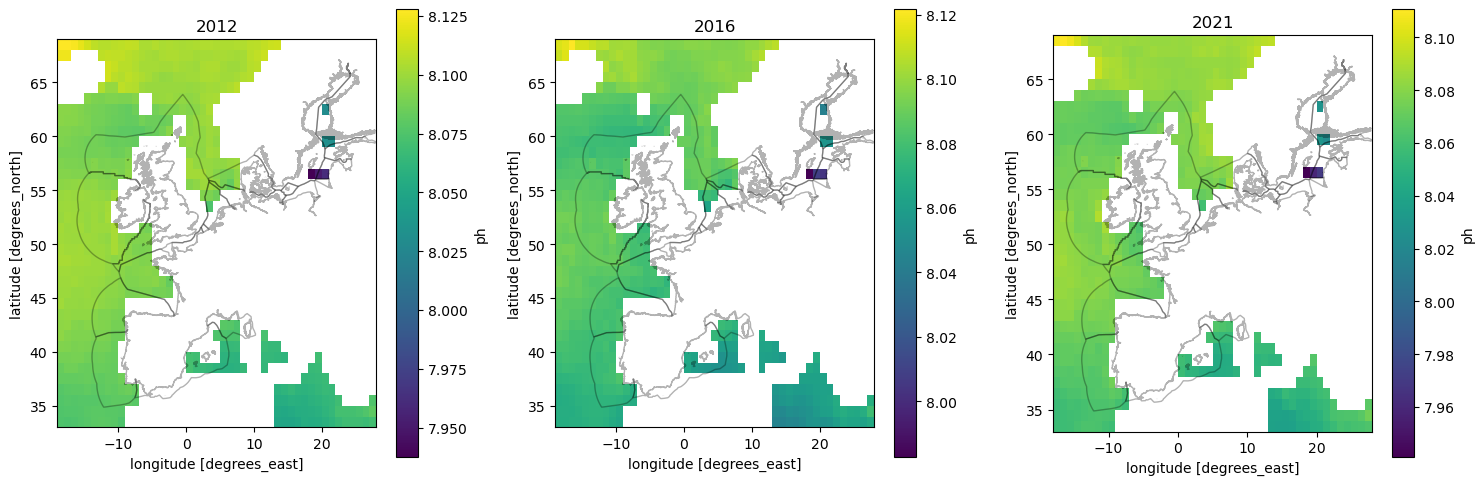

In [26]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i,year in enumerate(years):
    ph[str(year)].ph.plot(ax=ax[i], cmap='viridis')
    eezSDG14.plot(ax=ax[i], color='none', edgecolor='black', alpha=0.3)
    ax[i].set_title(year)
plt.tight_layout()

In [27]:
phData = pd.DataFrame(phCountryVal)
phData

,2012,2016,2021
Belgium,nan,nan,nan
Germany,8.096389,8.083338,8.075437
Denmark,8.090148,8.08142,8.079173
Estonia,nan,nan,nan
Spain,8.084052,8.0744295,8.068529
Finland,8.031056,8.050552,8.026776
France,8.08842,8.078483,8.071265
Ireland,8.097319,8.087274,8.078043
Lithuania,nan,nan,nan
Latvia,7.956884,8.006147,7.964427


### NOAA data
https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0220059

In [28]:
noaaPH = xr.open_dataset('../data/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')

In [29]:
noaaPH = noaaPH.sel(lon=slice(boundsEEZ[0],boundsEEZ[2]), lat=slice(boundsEEZ[1],boundsEEZ[3]))

In [30]:
years = [2012,2016,2021]
phYear = {}
for year in years:
    phYear["{0}".format(year)] = noaaPH.ph_total.sel(time=slice('{0}-01-01'.format(year),'{0}-12-31'.format(year))).mean(dim='time')

In [31]:
phCountry = {}
for year in years:  
    phCountry["{0}".format(year)] = {}
    for country in countries:
        phCountry["{0}".format(year)]["{0}".format(country)] = {}

In [32]:
for k,v in phYear.items():
    phYear[k] = phYear[k].rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    phYear[k] = phYear[k].rio.write_crs("epsg:4326", inplace=True)
    for country in countries:
        phCountry["{0}".format(k)][country] = phYear[k].rio.clip(eezSDG14[eezSDG14.Territory==country].geometry.apply(mapping), eezSDG14.crs).mean().values

In [33]:
phData = pd.DataFrame(phCountry)
phData.to_csv('../data/phDataNOAA.csv')
phData

,2012,2016,2021
Belgium,8.066332,8.057062,nan
Germany,8.067738,8.070016,8.077536
Denmark,8.085134,8.0792885,8.070046
Estonia,8.02835,8.063891,8.037472
Spain,8.090724,8.081096,8.072152
Finland,8.027017,8.057165,8.027941
France,8.093457,8.0852,8.074092
Ireland,8.0959425,8.085807,8.075813
Lithuania,8.03648,8.073564,8.051622
Latvia,8.014241,8.056093,8.028847


In [34]:
minVal = phYear['2012'].min().values
maxVal = phYear['2012'].max().values
for year in years:
    if phYear[str(year)].min().values < minVal:
        minVal = phYear[str(year)].min().values
    if phYear[str(year)].max().values > maxVal:
        maxVal = phYear[str(year)].max().values
minVal, maxVal

(array(7.97603655), array(8.15105629))

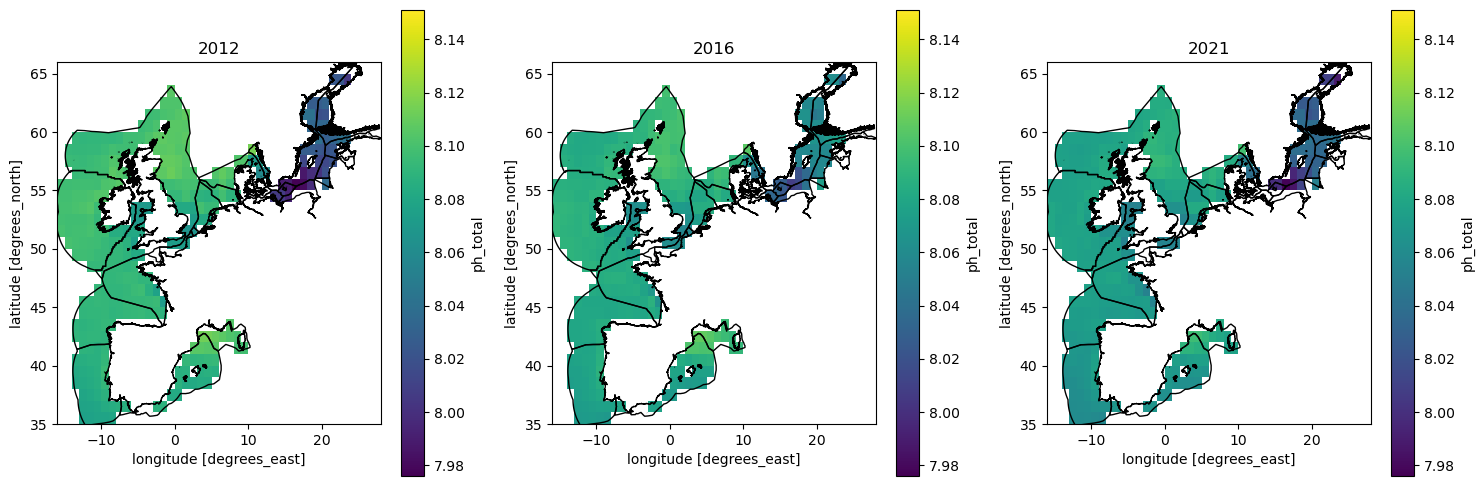

In [35]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i,year in enumerate(years):
    phYear[str(year)] = phYear[str(year)].rio.clip(eezSDG14.geometry.apply(mapping), eezSDG14.crs)
    phYear[str(year)].plot(ax=ax[i], cmap='viridis', vmin=minVal, vmax=maxVal)
    eezSDG14.plot(ax=ax[i], color='none', edgecolor='black')
    ax[i].set_title(year)
plt.tight_layout()
plt.savefig('../output/figs/phNOAA.pdf')

## Download data from Copernicus
[This solution not working](https://help.marine.copernicus.eu/en/articles/5182598-how-to-consume-the-opendap-api-and-cas-sso-using-python)

In [36]:
USERNAME = 'isaldivia1'
PASSWORD = getpass.getpass('Enter your password: ')
DATASET_ID = 'dataset-carbon-rep-monthly'

In [44]:
def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session, user_charset='utf-8')) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits 
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session, user_charset='utf-8')) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
    return data_store

In [45]:
copernicusmarine_datastore(DATASET_ID, USERNAME, PASSWORD)

KeyError: 'CASTGC'